In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import urllib
import cv2
import re
from PIL import Image, ImageOps
%matplotlib inline

In [23]:
carmax = pd.read_csv('../data/carmax_final_data.csv')
carvana = pd.read_csv('../data/carvana_final_data.csv')

In [24]:
carmax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50580 entries, 0 to 50579
Data columns (total 10 columns):
Unnamed: 0    50580 non-null int64
model         50580 non-null object
price         50580 non-null int64
mileage       50580 non-null int64
src           50580 non-null object
type          50580 non-null object
year          50580 non-null int64
make          50580 non-null object
trim          50580 non-null object
image-type    50580 non-null object
dtypes: int64(4), object(6)
memory usage: 3.9+ MB


In [25]:
carvana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12426 entries, 0 to 12425
Data columns (total 10 columns):
Unnamed: 0    12426 non-null int64
make          12426 non-null object
model         12426 non-null object
trim          12426 non-null object
type          12426 non-null object
price         12426 non-null int64
mileage       12426 non-null int64
src           12426 non-null object
year          12426 non-null int64
image-type    12426 non-null object
dtypes: int64(4), object(6)
memory usage: 970.9+ KB


In [26]:
carmax['org'] = 'carmax'
carvana['org'] = 'carvana'

In [27]:
carvana['id'] = carvana['Unnamed: 0']
carvana.drop('Unnamed: 0', axis=1, inplace=True)
carmax['id'] = carmax['Unnamed: 0']
carmax.drop('Unnamed: 0', axis=1, inplace=True)

In [28]:
carvana.head()

make          model               trim         type  price  mileage  \
0    AUDI             A3  1.8T Premium Plus  convertible  22200    41822   
1  JAGUAR             XK                XKR  convertible  34300    47179   
2   MAZDA  MX-5 MIATA RF               Club  convertible  25700     6445   
3     BMW       4 SERIES               428i  convertible  32800    17869   
4     BMW             Z4          SDrive35i  convertible  32700    29380   

                                                 src  year image-type  \
0  cdnblob.carvana.io/2000291164/post-large/norma...  2015   original   
1  cdnblob.carvana.io/2000287619/post-large/norma...  2011   original   
2  cdnblob.carvana.io/2000282627/post-large/norma...  2017   original   
3  cdnblob.carvana.io/2000283685/post-large/norma...  2016   original   
4  cdnblob.carvana.io/2000277443/post-large/norma...  2015   original   

       org  id  
0  carvana   0  
1  carvana   1  
2  carvana   2  
3  carvana   3  
4  carvana   4

In [29]:
carmax['make'] = carmax['make'].apply(lambda x: x.upper())

In [30]:
carmax.head()

model  price  mileage  \
0  undefined  19998    20000   
1  undefined  21998    20000   
2  undefined  19998    41000   
3  undefined  17998    29000   
4  undefined  20998    44000   

                                                 src   type  year   make trim  \
0  https://img2.carmax.com/img/vehicles/17325462/...  sedan  2016  ACURA  ILX   
1  https://img2.carmax.com/img/vehicles/17373223/...  sedan  2015  ACURA  TLX   
2  https://img2.carmax.com/img/vehicles/17221103/...  sedan  2015  ACURA  TLX   
3  https://img2.carmax.com/img/vehicles/17320660/...  sedan  2016  ACURA  ILX   
4  https://img2.carmax.com/img/vehicles/15666950/...  sedan  2016  ACURA  TLX   

  image-type     org  id  
0   original  carmax   0  
1   original  carmax   1  
2   original  carmax   2  
3   original  carmax   3  
4   original  carmax   4

In [31]:
all_cars = pd.concat([carmax, carvana], axis=0, ignore_index=True, sort=True)
all_cars = all_cars.sort_values('make').reset_index()
all_cars.drop('index', axis=1, inplace=True)

In [32]:
all_cars.head()

id image-type   make  mileage      model      org  price  \
0     0   original  ACURA    20000  undefined   carmax  19998   
1  2607   original  ACURA    46319        TLX  carvana  19200   
2  2614   original  ACURA    39069        TLX  carvana  19700   
3  2652   original  ACURA    45517        TLX  carvana  19700   
4  2671   original  ACURA    17525        ILX  carvana  18900   

                                                 src trim   type  year  
0  https://img2.carmax.com/img/vehicles/17325462/...  ILX  sedan  2016  
1  cdnblob.carvana.io/2000249304/post-large/norma...  3.5  sedan  2016  
2  cdnblob.carvana.io/2000243521/post-large/norma...  3.5  sedan  2016  
3  cdnblob.carvana.io/2000287679/post-large/norma...  2.4  sedan  2016  
4  cdnblob.carvana.io/2000284758/post-large/norma...  ILX  sedan  2016

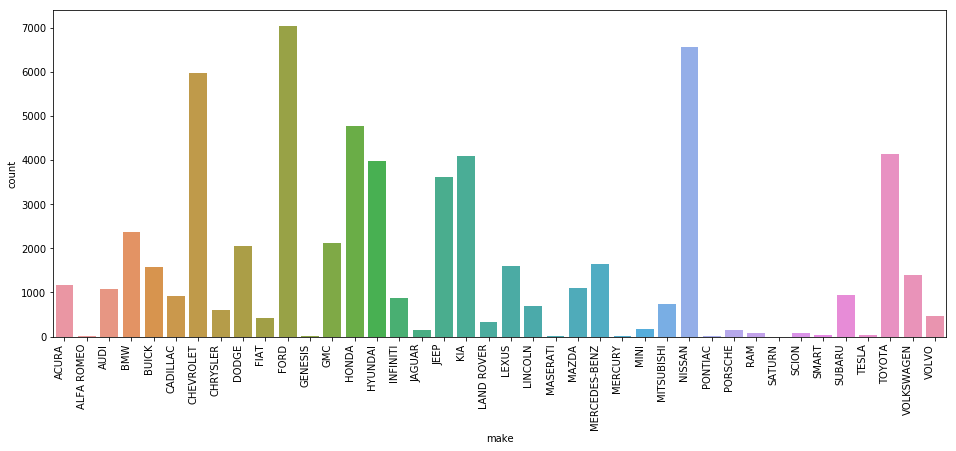

In [33]:
plt.figure(figsize=(16,6))
ax = sns.countplot(x='make', data=all_cars)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

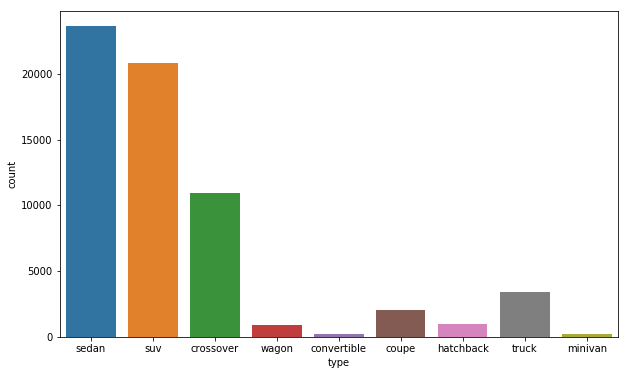

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(x='type', data=all_cars)

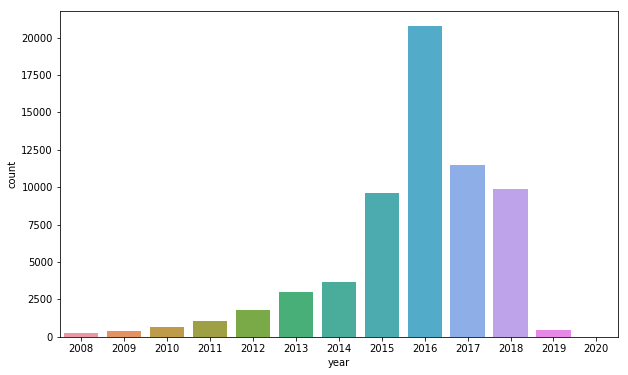

In [35]:
plt.figure(figsize=(10,6))
sns.countplot(x='year', data=all_cars)

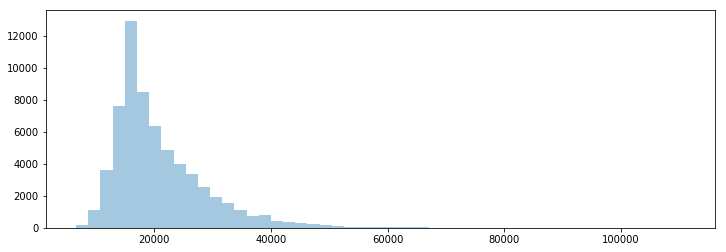

In [36]:
plt.figure(figsize=(12,4))
sns.distplot([all_cars['price']], kde=False)

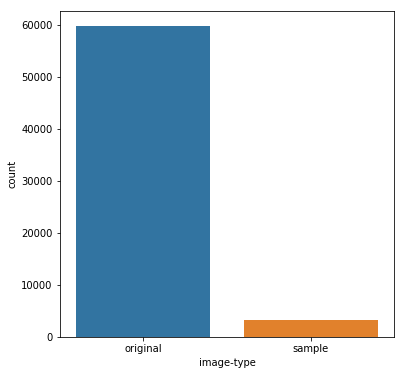

In [37]:
plt.figure(figsize=(6,6))
sns.countplot(x='image-type', data=all_cars)

In [38]:
len(all_cars[all_cars['image-type'] == 'original'])

59816

From all the data scraped, we are left with 60285 images of cars

In [39]:
def save_carmax(car_id, index):
    im_pth = '../images/carmax/' + str(car_id) + '.jpg'
    im = Image.open(im_pth)
    old_size = im.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    new_im.save('../images/final/' + str(desired_size) + '/' + str(index) + '.jpg')

In [40]:
def save_carvana(car_id, index):
    im_pth = '../images/carvana/' + str(car_id) + '.jpg'
    im = Image.open(im_pth)
    im = im.crop((73,0,673,im.size[1]))
    old_size = im.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    new_im = new_im.transpose(Image.FLIP_LEFT_RIGHT)
    new_im.save('../images/final/' + str(desired_size) + '/' + str(index) + '.jpg')

In [45]:
desired_size = 256
for i in range(len(all_cars)):
    img_type = all_cars.iloc[i]["image-type"]
    org = all_cars.iloc[i].org
    car_id = all_cars.iloc[i].id
    if img_type == 'sample':
        continue
    else:
        if org == 'carmax':
            save_carmax(car_id,i)
        else:
            save_carvana(car_id,i)

In [48]:
all_cars.to_csv('../data/final_data.csv')